<a href="https://colab.research.google.com/github/Shakib-IO/Graph-Network/blob/main/PyG_Message_Passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

In [3]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

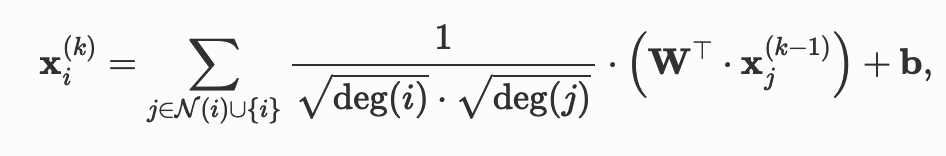

where neighboring node features are first transformed by a weight matrix
, normalized by their degree, and finally summed up. Lastly, we apply the bias vector
 to the aggregated output. This formula can be divided into the following steps:

1. Add self-loops to the adjacency matrix.
2. Linearly transform node feature matrix.
3. Compute normalization coefficients.
4. Normalize node features in.
5. Sum up neighboring node features ("add" aggregation).
6. Apply a final bias vector.



In [13]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        print("Edge", edge_index.shape)
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        print("After adding self loop", edge_index.shape)

        print("Before Linear transfomrm", x.shape)
        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        print("After Linear Transform", x.shape)

        # Step 3: Compute normalization.
        row, col = edge_index
        print("Row:", row.shape)
        print("Col:", col.shape)

        deg = degree(col, x.size(0), dtype=x.dtype)
        print("Degree:", deg.shape)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)
        print("After Propagation", out.shape)
        # Step 6: Apply a final bias vector.
        out = out + self.bias
        print("After Bias", out.shape)
        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [14]:
conv = GCNConv(1433, 32)
x = conv(dataset.x, dataset.edge_index)
print("Shape of X:", x.shape)

Edge torch.Size([2, 10556])
After adding self loop torch.Size([2, 13264])
Before Linear transfomrm torch.Size([2708, 1433])
After Linear Transform torch.Size([2708, 32])
Row: torch.Size([13264])
Col: torch.Size([13264])
Degree: torch.Size([2708])
After Propagation torch.Size([2708, 32])
After Bias torch.Size([2708, 32])
Shape of X: torch.Size([2708, 32])


In [ ]:
"""
def propagate(
        self,
        edge_index: Adj,
        size: Size = None,
        **kwargs: Any,
    ) -> Tensor:
        The initial call to start propagating messages.

        Args:
            edge_index (torch.Tensor or SparseTensor): A :class:`torch.Tensor`,
                a :class:`torch_sparse.SparseTensor` or a
                :class:`torch.sparse.Tensor` that defines the underlying
                graph connectivity/message passing flow.
                :obj:`edge_index` holds the indices of a general (sparse)
                assignment matrix of shape :obj:`[N, M]`.
                If :obj:`edge_index` is a :obj:`torch.Tensor`, its :obj:`dtype`
                should be :obj:`torch.long` and its shape needs to be defined
                as :obj:`[2, num_messages]` where messages from nodes in
                :obj:`edge_index[0]` are sent to nodes in :obj:`edge_index[1]`
                (in case :obj:`flow="source_to_target"`).
                If :obj:`edge_index` is a :class:`torch_sparse.SparseTensor` or
                a :class:`torch.sparse.Tensor`, its sparse indices
                :obj:`(row, col)` should relate to :obj:`row = edge_index[1]`
                and :obj:`col = edge_index[0]`.
                The major difference between both formats is that we need to
                input the *transposed* sparse adjacency matrix into
                :meth:`propagate`.
            size ((int, int), optional): The size :obj:`(N, M)` of the
                assignment matrix in case :obj:`edge_index` is a
                :class:`torch.Tensor`.
                If set to :obj:`None`, the size will be automatically inferred
                and assumed to be quadratic.
                This argument is ignored in case :obj:`edge_index` is a
                :class:`torch_sparse.SparseTensor` or
                a :class:`torch.sparse.Tensor`. (default: :obj:`None`)
            **kwargs: Any additional data which is needed to construct and
                aggregate messages, and to update node embeddings.

        decomposed_layers = 1 if self.explain else self.decomposed_layers

        for hook in self._propagate_forward_pre_hooks.values():
            res = hook(self, (edge_index, size, kwargs))
            if res is not None:
                edge_index, size, kwargs = res

        mutable_size = self._check_input(edge_index, size)

        # Run "fused" message and aggregation (if applicable).
        fuse = False
        if self.fuse and not self.explain:
            if is_sparse(edge_index):
                fuse = True
            elif (not torch.jit.is_scripting()
                  and isinstance(edge_index, EdgeIndex)):
                if (self.SUPPORTS_FUSED_EDGE_INDEX
                        and edge_index.is_sorted_by_col):
                    fuse = True

        if fuse:
            coll_dict = self._collect(self._fused_user_args, edge_index,
                                      mutable_size, kwargs)

            msg_aggr_kwargs = self.inspector.collect_param_data(
                'message_and_aggregate', coll_dict)
            for hook in self._message_and_aggregate_forward_pre_hooks.values():
                res = hook(self, (edge_index, msg_aggr_kwargs))
                if res is not None:
                    edge_index, msg_aggr_kwargs = res
            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)
            for hook in self._message_and_aggregate_forward_hooks.values():
                res = hook(self, (edge_index, msg_aggr_kwargs), out)
                if res is not None:
                    out = res

            update_kwargs = self.inspector.collect_param_data(
                'update', coll_dict)
            out = self.update(out, **update_kwargs)

        else:  # Otherwise, run both functions in separation.
            if decomposed_layers > 1:
                user_args = self._user_args
                decomp_args = {a[:-2] for a in user_args if a[-2:] == '_j'}
                decomp_kwargs = {
                    a: kwargs[a].chunk(decomposed_layers, -1)
                    for a in decomp_args
                }
                decomp_out = []

            for i in range(decomposed_layers):
                if decomposed_layers > 1:
                    for arg in decomp_args:
                        kwargs[arg] = decomp_kwargs[arg][i]

                coll_dict = self._collect(self._user_args, edge_index,
                                          mutable_size, kwargs)

                msg_kwargs = self.inspector.collect_param_data(
                    'message', coll_dict)
                for hook in self._message_forward_pre_hooks.values():
                    res = hook(self, (msg_kwargs, ))
                    if res is not None:
                        msg_kwargs = res[0] if isinstance(res, tuple) else res
                out = self.message(**msg_kwargs)
                for hook in self._message_forward_hooks.values():
                    res = hook(self, (msg_kwargs, ), out)
                    if res is not None:
                        out = res

                if self.explain:
                    explain_msg_kwargs = self.inspector.collect_param_data(
                        'explain_message', coll_dict)
                    out = self.explain_message(out, **explain_msg_kwargs)

                aggr_kwargs = self.inspector.collect_param_data(
                    'aggregate', coll_dict)
                for hook in self._aggregate_forward_pre_hooks.values():
                    res = hook(self, (aggr_kwargs, ))
                    if res is not None:
                        aggr_kwargs = res[0] if isinstance(res, tuple) else res

                out = self.aggregate(out, **aggr_kwargs)

                for hook in self._aggregate_forward_hooks.values():
                    res = hook(self, (aggr_kwargs, ), out)
                    if res is not None:
                        out = res

                update_kwargs = self.inspector.collect_param_data(
                    'update', coll_dict)
                out = self.update(out, **update_kwargs)

                if decomposed_layers > 1:
                    decomp_out.append(out)

            if decomposed_layers > 1:
                out = torch.cat(decomp_out, dim=-1)

        for hook in self._propagate_forward_hooks.values():
            res = hook(self, (edge_index, mutable_size, kwargs), out)
            if res is not None:
                out = res

        return out
"""